<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/SegFormer/Fine_tune_SegFormer_on_custom_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fine-tune SegFormer on a custom dataset

In this notebook, we are going to fine-tune [SegFormerForSemanticSegmentation](https://huggingface.co/docs/transformers/main/model_doc/segformer#transformers.SegformerForSemanticSegmentation) on a custom **semantic segmentation** dataset. In semantic segmentation, the goal for the model is to label each pixel of an image with one of a list of predefined classes.

We load the encoder of the model with weights pre-trained on ImageNet-1k, and fine-tune it together with the decoder head, which starts with randomly initialized weights.

In [1]:
!pip install -q transformers datasets evaluate

## Download toy dataset

Here we download a small subset of the ADE20k dataset, which is an important benchmark for semantic segmentation. It contains 150 labels.

I've made a small subset just for demonstration purposes (namely the 10 first training and 10 first validation images + segmentation maps). The goal for the model is to overfit this tiny dataset (because that makes sure that it'll work on a larger scale).

In [8]:
import requests, zipfile, io

def download_data():
    url = "https://www.dropbox.com/s/l1e45oht447053f/ADE20k_toy_dataset.zip?dl=1"
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()

download_data()

Note that this dataset is now also available on the hub :) you can directly check out the images [in your browser](scene_parse_150)! It can be easily loaded as follows (note that loading will take some time as the dataset is several GB's large):

In [7]:
from datasets import load_dataset

load_entire_dataset = False

if load_entire_dataset:
  dataset = load_dataset("scene_parse_150")

## Define PyTorch dataset and dataloaders

Here we define a [custom PyTorch dataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html). Each item of the dataset consists of an image and a corresponding segmentation map.

In [2]:
from torch.utils.data import Dataset
import os
from PIL import Image

class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, image_processor, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            image_processor (SegFormerImageProcessor): image processor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.image_processor = image_processor
        self.train = train

        sub_path = "training" if self.train else "validation"
        self.img_dir = os.path.join(self.root_dir, "images", sub_path)
        self.ann_dir = os.path.join(self.root_dir, "annotations", sub_path)

        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
          image_file_names.extend(files)
        self.images = sorted(image_file_names)

        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
          annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = Image.open(os.path.join(self.img_dir, self.images[idx]))
        segmentation_map = Image.open(os.path.join(self.ann_dir, self.annotations[idx]))

        # randomly crop + pad both image and segmentation map to same size
        encoded_inputs = self.image_processor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

Let's initialize the training + validation datasets. Important: we initialize the image processor with `reduce_labels=True`, as the classes in ADE20k go from 0 to 150, with 0 meaning "background". However, we want the labels to go from 0 to 149, and only train the model to recognize the 150 classes (which don't include "background"). Hence, we'll reduce all labels by 1 and replace 0 by 255, which is the `ignore_index` of SegFormer's loss function.

In [16]:
from transformers import SegformerImageProcessor
import os
from pathlib import Path

# if on google colab
# root_dir = '/content/ADE20k_toy_dataset' 
# if on local machine
wd = Path(os.getcwd())
root_dir = os.path.join(wd,"ADE20k_toy_dataset")

image_processor = SegformerImageProcessor(reduce_labels=True)

train_dataset = SemanticSegmentationDataset(root_dir=root_dir, image_processor=image_processor)
valid_dataset = SemanticSegmentationDataset(root_dir=root_dir, image_processor=image_processor, train=False)

In [19]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))

Number of training examples: 10
Number of validation examples: 10


Let's verify a random example:

In [20]:
encoded_inputs = train_dataset[0]

In [21]:
encoded_inputs["pixel_values"].shape

torch.Size([3, 512, 512])

In [22]:
encoded_inputs["labels"].shape

torch.Size([512, 512])

In [23]:
encoded_inputs["labels"]

tensor([[255, 255, 255,  ...,   5,   5,   5],
        [255,   5,   5,  ...,   5,   5,   5],
        [255,   5,   5,  ...,   5,   5,   5],
        ...,
        [  3,   3,   3,  ...,   0,   0, 255],
        [  3,   3,   3,  ...,   0,   0, 255],
        [  3,   3,   3,  ...,   0,   0,   0]])

In [24]:
encoded_inputs["labels"].squeeze().unique()

tensor([  0,   3,   4,   5,  12,  17,  31,  32,  42,  43,  87,  96, 104, 125,
        138, 149, 255])

## Dataloader

Next, we define corresponding dataloaders, but what is a Dataloader? watch this [video](https://www.youtube.com/watch?v=Sj-gIb0QiRM)

If the dataset has huge amaount of data, then it unfeasible to train all the dataset in one go. This is why the dataset is divided into batches. If the dataset has 1000 images, and my GPU with it's VRAM and current model i want to train it on hadn handle only 2 images at the time, i will create batches of dimension 2, for a total of 1000/2 = 500 batches. After 500 batches of training, I will have comepleted 1 single epoch ( training over the entire dataset).

What if i want to apply augmentations on this dataset, in order to reduce overfitting and other elements. How do apply this augmentation ? 

The dataloader is class which doens't load the entire dataset in the RAM, but it loads it in littls segments.
The endreuslt of the dataloader is to give the neural networl a batch to train, but this batch is not in sequential order from the dataset, but is mostly at random (look the vidoe for a better understanding). It also allows us to apply random augmentations in order to make the neural network more robust. This way we potentially have a lot more data to train on

In [25]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=2)

In [26]:
batch = next(iter(train_dataloader))

In [27]:
for k,v in batch.items():
  print(k, v.shape)

pixel_values torch.Size([2, 3, 512, 512])
labels torch.Size([2, 512, 512])


In [28]:
batch["labels"].shape

torch.Size([2, 512, 512])

In [30]:
mask = (batch["labels"] != 255)
mask

tensor([[[False, False, False,  ..., False, False, False],
         [False,  True,  True,  ...,  True, False, False],
         [False,  True,  True,  ...,  True, False, False],
         ...,
         [False,  True,  True,  ...,  True,  True, False],
         [False,  True,  True,  ...,  True,  True, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False,  True,  ...,  True, False, False],
         [ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True, False],
         ...,
         [False,  True,  True,  ...,  True,  True, False],
         [False,  True,  True,  ...,  True,  True, False],
         [False, False, False,  ..., False, False, False]]])

In [31]:
batch["labels"][mask]

tensor([0, 0, 0,  ..., 0, 0, 0])

## Define the model

Here we load the model, and equip the encoder with weights pre-trained on ImageNet-1k (we take the smallest variant, `nvidia/mit-b0` here, but you can take a bigger one like `nvidia/mit-b5` from the [hub](https://huggingface.co/models?other=segformer)). We also set the `id2label` and `label2id` mappings, which will be useful when performing inference.

In [32]:
from transformers import SegformerForSemanticSegmentation
import json
from huggingface_hub import hf_hub_download

# load id2label mapping from a JSON on the hub
repo_id = "huggingface/label-files"
filename = "ade20k-id2label.json"
id2label = json.load(open(hf_hub_download(repo_id=repo_id, filename=filename, repo_type="dataset"), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

# define model
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=150,
                                                         id2label=id2label,
                                                         label2id=label2id,
)

ade20k-id2label.json:   0%|          | 0.00/2.81k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/14.4M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Fine-tune the model

Here we fine-tune the model in native PyTorch, using the AdamW optimizer. We use the same learning rate as the one reported in the [paper](https://arxiv.org/abs/2105.15203).

It's also very useful to track metrics during training. For semantic segmentation, typical metrics include the mean intersection-over-union (mIoU) and pixel-wise accuracy. These are available in the Datasets library. We can load it as follows:

In [33]:
import evaluate

metric = evaluate.load("mean_iou")

In [34]:
image_processor.do_reduce_labels

True

In [35]:
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

# define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.train()

for epoch in range(200):  # loop over the dataset multiple times
   print("Epoch:", epoch)
   
   for idx, batch in enumerate(tqdm(train_dataloader)):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)    # the inputs of the batch
        labels = batch["labels"].to(device)                # get the label batches

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)    # give the model to dataloader
        loss, logits = outputs.loss, outputs.logits                  # receives the ouput of suhc dataloader

        loss.backward() 
        optimizer.step()

        # evaluate
        with torch.no_grad():
          upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
          predicted = upsampled_logits.argmax(dim=1)

          # note that the metric expects predictions + labels as numpy arrays
          metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

        # let's print loss and metrics every 100 batches
        if idx % 100 == 0:
          # currently using _compute instead of compute
          # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
          metrics = metric._compute(
                  predictions=predicted.cpu(),
                  references=labels.cpu(),
                  num_labels=len(id2label),
                  ignore_index=255,
                  reduce_labels=False, # we've already reduced the labels ourselves
              )

          print("Loss:", loss.item())
          print("Mean_iou:", metrics["mean_iou"])
          print("Mean accuracy:", metrics["mean_accuracy"])

Epoch: 0


  0%|          | 0/5 [00:00<?, ?it/s]

/home/helldiver/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/home/helldiver/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


Loss: 5.011922359466553
Mean_iou: 0.0005248829621805801
Mean accuracy: 0.012569659957142458
Epoch: 1


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.777725696563721
Mean_iou: 0.0043437530919405234
Mean accuracy: 0.03463169264886149
Epoch: 2


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.867761611938477
Mean_iou: 0.00906196771597907
Mean accuracy: 0.11079274059648937
Epoch: 3


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.6793718338012695
Mean_iou: 0.011751562492878693
Mean accuracy: 0.11483583235262648
Epoch: 4


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.826497554779053
Mean_iou: 0.00466845277804597
Mean accuracy: 0.07935530933132304
Epoch: 5


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.402787685394287
Mean_iou: 0.02455116082225827
Mean accuracy: 0.18666966306606322
Epoch: 6


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.371307849884033
Mean_iou: 0.028234528052042768
Mean accuracy: 0.2860284548135092
Epoch: 7


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.7896201610565186
Mean_iou: 0.07483865006874903
Mean accuracy: 0.23310244571870756
Epoch: 8


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.8768630027770996
Mean_iou: 0.049597480384551335
Mean accuracy: 0.25860792505926117
Epoch: 9


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.654078483581543
Mean_iou: 0.08349346452884399
Mean accuracy: 0.2849299169637154
Epoch: 10


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.016380786895752
Mean_iou: 0.06399113579302701
Mean accuracy: 0.3006768374878192
Epoch: 11


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.4176130294799805
Mean_iou: 0.24841344962159434
Mean accuracy: 0.522198668361518
Epoch: 12


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.469559669494629
Mean_iou: 0.15904980675415945
Mean accuracy: 0.2778156294355867
Epoch: 13


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.8499393463134766
Mean_iou: 0.08649462868010768
Mean accuracy: 0.33736957971213755
Epoch: 14


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.3120462894439697
Mean_iou: 0.286281086249399
Mean accuracy: 0.6064977780145578
Epoch: 15


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.710275411605835
Mean_iou: 0.12086062436560553
Mean accuracy: 0.37364065219163983
Epoch: 16


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.0654098987579346
Mean_iou: 0.16570063032918134
Mean accuracy: 0.4164299767991962
Epoch: 17


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.8348515033721924
Mean_iou: 0.15597860935201538
Mean accuracy: 0.2288663516387693
Epoch: 18


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.095248222351074
Mean_iou: 0.1309849517104988
Mean accuracy: 0.26855796236895896
Epoch: 19


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.501530885696411
Mean_iou: 0.12996744230028956
Mean accuracy: 0.3783920013277896
Epoch: 20


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.213921546936035
Mean_iou: 0.16161623448474924
Mean accuracy: 0.2908768573403671
Epoch: 21


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.8886911869049072
Mean_iou: 0.2508975282432261
Mean accuracy: 0.46963302754102887
Epoch: 22


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.7692700624465942
Mean_iou: 0.6775508726615104
Mean accuracy: 0.8316734014988553
Epoch: 23


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.0993998050689697
Mean_iou: 0.39902550206172704
Mean accuracy: 0.5885096570975544
Epoch: 24


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.4638915061950684
Mean_iou: 0.2465576484502634
Mean accuracy: 0.5402159511429173
Epoch: 25


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.474595546722412
Mean_iou: 0.26147328067216824
Mean accuracy: 0.41564755698610395
Epoch: 26


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.507167100906372
Mean_iou: 0.10840493891635952
Mean accuracy: 0.20018887690750306
Epoch: 27


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.107929229736328
Mean_iou: 0.4595057296570899
Mean accuracy: 0.6074854825609214
Epoch: 28


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.369208574295044
Mean_iou: 0.27970476275981426
Mean accuracy: 0.4818869545417421
Epoch: 29


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.134777069091797
Mean_iou: 0.18878997700042835
Mean accuracy: 0.3191886615559616
Epoch: 30


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.1463351249694824
Mean_iou: 0.2927565408412949
Mean accuracy: 0.5450707814871378
Epoch: 31


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.7762309312820435
Mean_iou: 0.20740604548247202
Mean accuracy: 0.3525467074584046
Epoch: 32


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.2332403659820557
Mean_iou: 0.1326249431293283
Mean accuracy: 0.2492430268894786
Epoch: 33


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.1362738609313965
Mean_iou: 0.11056598219386879
Mean accuracy: 0.19844817540226287
Epoch: 34


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.1318814754486084
Mean_iou: 0.15815830922422827
Mean accuracy: 0.28760004937630235
Epoch: 35


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.1710314750671387
Mean_iou: 0.34096817214038777
Mean accuracy: 0.48963882439761713
Epoch: 36


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.7645342350006104
Mean_iou: 0.2503748058370375
Mean accuracy: 0.3706177224037173
Epoch: 37


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.9313181638717651
Mean_iou: 0.18351090434065134
Mean accuracy: 0.25727485055320853
Epoch: 38


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.130018711090088
Mean_iou: 0.42610901375835686
Mean accuracy: 0.7566271568559808
Epoch: 39


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.049814462661743
Mean_iou: 0.3790329687365826
Mean accuracy: 0.5313007019820906
Epoch: 40


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.114372491836548
Mean_iou: 0.27608530731726577
Mean accuracy: 0.5112886265893476
Epoch: 41


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3715779781341553
Mean_iou: 0.2260075682723088
Mean accuracy: 0.3615746031809989
Epoch: 42


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.0243446826934814
Mean_iou: 0.42516888690568516
Mean accuracy: 0.7218450272373629
Epoch: 43


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0200104713439941
Mean_iou: 0.41372901960234415
Mean accuracy: 0.6769636064058615
Epoch: 44


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.534379243850708
Mean_iou: 0.177883833773431
Mean accuracy: 0.3215450005603468
Epoch: 45


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.7461003065109253
Mean_iou: 0.2403736882737238
Mean accuracy: 0.3353436918197479
Epoch: 46


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.6550040245056152
Mean_iou: 0.2344614319971269
Mean accuracy: 0.3191640811157287
Epoch: 47


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.9866024255752563
Mean_iou: 0.3191150342001457
Mean accuracy: 0.5526463161681799
Epoch: 48


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.7695403099060059
Mean_iou: 0.4136364838166098
Mean accuracy: 0.5488767494472779
Epoch: 49


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.7655174732208252
Mean_iou: 0.3879128648078337
Mean accuracy: 0.4715392260954485
Epoch: 50


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4881680011749268
Mean_iou: 0.1870054923017839
Mean accuracy: 0.2544720001338659
Epoch: 51


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1428114175796509
Mean_iou: 0.19742040312724046
Mean accuracy: 0.29427722259070305
Epoch: 52


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2985035181045532
Mean_iou: 0.11802481038477956
Mean accuracy: 0.16255555772098126
Epoch: 53


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4492075443267822
Mean_iou: 0.6480147160625123
Mean accuracy: 0.7936013232821285
Epoch: 54


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.394270420074463
Mean_iou: 0.4943448531542221
Mean accuracy: 0.7735440770824852
Epoch: 55


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7425129413604736
Mean_iou: 0.5236147999423734
Mean accuracy: 0.7277706042296423
Epoch: 56


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4296610355377197
Mean_iou: 0.5779863541416488
Mean accuracy: 0.61801890309973
Epoch: 57


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.450563907623291
Mean_iou: 0.52732594067361
Mean accuracy: 0.645218639675541
Epoch: 58


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4594529867172241
Mean_iou: 0.2976267359952763
Mean accuracy: 0.40813201170755486
Epoch: 59


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.427217721939087
Mean_iou: 0.1429892126932803
Mean accuracy: 0.2688962793856152
Epoch: 60


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.6205337047576904
Mean_iou: 0.2529978230834511
Mean accuracy: 0.382848469873279
Epoch: 61


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2904771566390991
Mean_iou: 0.44803268482402153
Mean accuracy: 0.5009415663132748
Epoch: 62


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1600452661514282
Mean_iou: 0.2813901045589501
Mean accuracy: 0.3892582536688575
Epoch: 63


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3401514291763306
Mean_iou: 0.2890615415992033
Mean accuracy: 0.40622724349161676
Epoch: 64


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3662303686141968
Mean_iou: 0.29186772215694384
Mean accuracy: 0.4063907561027953
Epoch: 65


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3750550746917725
Mean_iou: 0.1981703063651353
Mean accuracy: 0.26445485517594663
Epoch: 66


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8824142813682556
Mean_iou: 0.42997298801479567
Mean accuracy: 0.6189244695931108
Epoch: 67


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1226673126220703
Mean_iou: 0.5424129762002113
Mean accuracy: 0.6492975269131934
Epoch: 68


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3657912015914917
Mean_iou: 0.12010968327618103
Mean accuracy: 0.20379875022694335
Epoch: 69


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5296119451522827
Mean_iou: 0.8032250082824912
Mean accuracy: 0.8592610282300992
Epoch: 70


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9170288443565369
Mean_iou: 0.33672135372615264
Mean accuracy: 0.39312070576447017
Epoch: 71


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0164867639541626
Mean_iou: 0.7328708416258966
Mean accuracy: 0.7928060851805756
Epoch: 72


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3746516704559326
Mean_iou: 0.11424090684774614
Mean accuracy: 0.19875771289050692
Epoch: 73


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0239421129226685
Mean_iou: 0.25123223220338703
Mean accuracy: 0.3528748077606138
Epoch: 74


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4403513669967651
Mean_iou: 0.13608151314928557
Mean accuracy: 0.22506437843778632
Epoch: 75


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0458885431289673
Mean_iou: 0.5442218887811362
Mean accuracy: 0.6579826944633022
Epoch: 76


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3680639266967773
Mean_iou: 0.36974018557031335
Mean accuracy: 0.6191873472936007
Epoch: 77


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.092476725578308
Mean_iou: 0.23627596144260046
Mean accuracy: 0.3451142943956181
Epoch: 78


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1799323558807373
Mean_iou: 0.3027561431449094
Mean accuracy: 0.42580973242422027
Epoch: 79


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1505346298217773
Mean_iou: 0.3142634208014366
Mean accuracy: 0.42715536196776577
Epoch: 80


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.92014080286026
Mean_iou: 0.2726074446306346
Mean accuracy: 0.3607245131825882
Epoch: 81


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6736984848976135
Mean_iou: 0.4014769237546536
Mean accuracy: 0.6206923883266046
Epoch: 82


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7513067126274109
Mean_iou: 0.4769462719594404
Mean accuracy: 0.6511089497837286
Epoch: 83


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6602576375007629
Mean_iou: 0.4510026265029056
Mean accuracy: 0.660612328639338
Epoch: 84


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.077921986579895
Mean_iou: 0.2440627835002433
Mean accuracy: 0.3738266079027434
Epoch: 85


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.064640760421753
Mean_iou: 0.23193300151880278
Mean accuracy: 0.35527590020283556
Epoch: 86


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.629535973072052
Mean_iou: 0.46891952516013363
Mean accuracy: 0.7291791499860864
Epoch: 87


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7260984182357788
Mean_iou: 0.321991215039017
Mean accuracy: 0.4345729665863105
Epoch: 88


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7716104984283447
Mean_iou: 0.7360367033713345
Mean accuracy: 0.7977222254148143
Epoch: 89


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7232843041419983
Mean_iou: 0.2962680442788942
Mean accuracy: 0.4067394074650753
Epoch: 90


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6397161483764648
Mean_iou: 0.36435862395777474
Mean accuracy: 0.5292333372945789
Epoch: 91


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2396496534347534
Mean_iou: 0.2831423022011234
Mean accuracy: 0.39866886997620327
Epoch: 92


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8391905426979065
Mean_iou: 0.4987264509827382
Mean accuracy: 0.5771690451216103
Epoch: 93


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8110579252243042
Mean_iou: 0.2302807123859
Mean accuracy: 0.3763657245299926
Epoch: 94


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8934684991836548
Mean_iou: 0.40953150594997795
Mean accuracy: 0.5668589446344622
Epoch: 95


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8001630902290344
Mean_iou: 0.37255197091694225
Mean accuracy: 0.4843440587108927
Epoch: 96


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6812042593955994
Mean_iou: 0.33072426497900026
Mean accuracy: 0.41995288402904735
Epoch: 97


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8162728548049927
Mean_iou: 0.41512461932808853
Mean accuracy: 0.5161904232814875
Epoch: 98


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7490929961204529
Mean_iou: 0.5550224780678337
Mean accuracy: 0.6694614642600002
Epoch: 99


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9146286845207214
Mean_iou: 0.35015224812997875
Mean accuracy: 0.43896840042041135
Epoch: 100


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.72530198097229
Mean_iou: 0.1380071935158384
Mean accuracy: 0.2343663533492815
Epoch: 101


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.826221764087677
Mean_iou: 0.24138250545457604
Mean accuracy: 0.44273061107860623
Epoch: 102


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6963839530944824
Mean_iou: 0.8156676632834008
Mean accuracy: 0.8696543717699626
Epoch: 103


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8599891066551208
Mean_iou: 0.44052948406074693
Mean accuracy: 0.5159945056916404
Epoch: 104


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.662419319152832
Mean_iou: 0.26214364066985124
Mean accuracy: 0.5108499806555028
Epoch: 105


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7498379945755005
Mean_iou: 0.5156411868668497
Mean accuracy: 0.6309891932638436
Epoch: 106


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.36356157064437866
Mean_iou: 0.7211980369442001
Mean accuracy: 0.8283983893518783
Epoch: 107


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9311953783035278
Mean_iou: 0.305178008050644
Mean accuracy: 0.4435318519551178
Epoch: 108


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7021865844726562
Mean_iou: 0.6109090540336571
Mean accuracy: 0.6980309122974997
Epoch: 109


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.39623990654945374
Mean_iou: 0.5285058065853586
Mean accuracy: 0.5894861177175973
Epoch: 110


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5464546084403992
Mean_iou: 0.7473608648294557
Mean accuracy: 0.8014513708782712
Epoch: 111


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9651891589164734
Mean_iou: 0.19115586325739173
Mean accuracy: 0.2934693201296875
Epoch: 112


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4476131498813629
Mean_iou: 0.49811016653247503
Mean accuracy: 0.7659189329767794
Epoch: 113


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2838335633277893
Mean_iou: 0.7270429648816655
Mean accuracy: 0.8594093125343402
Epoch: 114


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6908453702926636
Mean_iou: 0.45528591908879623
Mean accuracy: 0.5392630229285699
Epoch: 115


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4988705813884735
Mean_iou: 0.4572870216106118
Mean accuracy: 0.5538808744781043
Epoch: 116


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6478915810585022
Mean_iou: 0.4677031307103908
Mean accuracy: 0.5475536009710927
Epoch: 117


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.57595294713974
Mean_iou: 0.3787874540338134
Mean accuracy: 0.4437392761408655
Epoch: 118


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2562074363231659
Mean_iou: 0.6618528723858481
Mean accuracy: 0.8494129600210493
Epoch: 119


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.134250208735466
Mean_iou: 0.46892679824405
Mean accuracy: 0.7131841580709628
Epoch: 120


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6390811800956726
Mean_iou: 0.2984680853913094
Mean accuracy: 0.5237747003651569
Epoch: 121


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5968257784843445
Mean_iou: 0.18161205828504492
Mean accuracy: 0.2909447762309158
Epoch: 122


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3890618085861206
Mean_iou: 0.4564681736603008
Mean accuracy: 0.696630137936843
Epoch: 123


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.13060684502124786
Mean_iou: 0.43952039745102955
Mean accuracy: 0.7245539229075009
Epoch: 124


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.25915318727493286
Mean_iou: 0.8219802150092538
Mean accuracy: 0.8612202183809121
Epoch: 125


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8057178258895874
Mean_iou: 0.26459177329474
Mean accuracy: 0.3332550513593802
Epoch: 126


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3250972330570221
Mean_iou: 0.4968089635801451
Mean accuracy: 0.7058455668824888
Epoch: 127


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.32185691595077515
Mean_iou: 0.5083467497465018
Mean accuracy: 0.595526661289202
Epoch: 128


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.583146333694458
Mean_iou: 0.1851491040077161
Mean accuracy: 0.2727753313332688
Epoch: 129


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2421341836452484
Mean_iou: 0.7261033730221003
Mean accuracy: 0.8346777594758814
Epoch: 130


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2354428619146347
Mean_iou: 0.8310455153493512
Mean accuracy: 0.8507957278108459
Epoch: 131


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.38499006628990173
Mean_iou: 0.4776422132000867
Mean accuracy: 0.6446573520861865
Epoch: 132


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.613416314125061
Mean_iou: 0.4823701788515272
Mean accuracy: 0.5585006309399025
Epoch: 133


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3109663128852844
Mean_iou: 0.45935625448486733
Mean accuracy: 0.7043948949787778
Epoch: 134


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.24287928640842438
Mean_iou: 0.8377011890413626
Mean accuracy: 0.8563392940147441
Epoch: 135


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5238998532295227
Mean_iou: 0.33112837281800545
Mean accuracy: 0.4182639655796673
Epoch: 136


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3904058635234833
Mean_iou: 0.4055656661094435
Mean accuracy: 0.5791407484388696
Epoch: 137


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6198957562446594
Mean_iou: 0.4803826953138869
Mean accuracy: 0.5250963872242974
Epoch: 138


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3370063900947571
Mean_iou: 0.49686187986618646
Mean accuracy: 0.7732372797840373
Epoch: 139


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.49548494815826416
Mean_iou: 0.7180434463072393
Mean accuracy: 0.7530086025242513
Epoch: 140


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5469360947608948
Mean_iou: 0.32097770394326774
Mean accuracy: 0.36152339398880834
Epoch: 141


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.10052204132080078
Mean_iou: 0.4803272215820309
Mean accuracy: 0.728945880161691
Epoch: 142


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5983233451843262
Mean_iou: 0.5697042027717966
Mean accuracy: 0.6283361878574916
Epoch: 143


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.670707643032074
Mean_iou: 0.4526076114715067
Mean accuracy: 0.5002946769313869
Epoch: 144


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.48908302187919617
Mean_iou: 0.2893057561676296
Mean accuracy: 0.3744182534548763
Epoch: 145


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4647299647331238
Mean_iou: 0.542977147282956
Mean accuracy: 0.5951977282560096
Epoch: 146


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.511292576789856
Mean_iou: 0.35844691858509964
Mean accuracy: 0.5150464251626381
Epoch: 147


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.599087655544281
Mean_iou: 0.2617127007701417
Mean accuracy: 0.34583206735249017
Epoch: 148


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4285862445831299
Mean_iou: 0.5829809294906435
Mean accuracy: 0.65452957292966
Epoch: 149


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5085068345069885
Mean_iou: 0.348495333404579
Mean accuracy: 0.42991175105031854
Epoch: 150


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.31606853008270264
Mean_iou: 0.7376634876268388
Mean accuracy: 0.8523304688622333
Epoch: 151


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6036607027053833
Mean_iou: 0.342821517859094
Mean accuracy: 0.3895226314523484
Epoch: 152


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.36813390254974365
Mean_iou: 0.5887169986641028
Mean accuracy: 0.6628591775214203
Epoch: 153


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3507192134857178
Mean_iou: 0.41744589028339324
Mean accuracy: 0.5979832705706376
Epoch: 154


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.558937668800354
Mean_iou: 0.36091803941087996
Mean accuracy: 0.423769588025614
Epoch: 155


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4175236225128174
Mean_iou: 0.719694287206306
Mean accuracy: 0.7433202190832713
Epoch: 156


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4427906572818756
Mean_iou: 0.5539965535948147
Mean accuracy: 0.6021761032852792
Epoch: 157


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4125269055366516
Mean_iou: 0.45862768310867075
Mean accuracy: 0.5902448995116443
Epoch: 158


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5156101584434509
Mean_iou: 0.5234373304712283
Mean accuracy: 0.5629558845604065
Epoch: 159


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2798052132129669
Mean_iou: 0.7540577786748549
Mean accuracy: 0.8742677954119894
Epoch: 160


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.40225139260292053
Mean_iou: 0.5891939570349708
Mean accuracy: 0.7040669897194536
Epoch: 161


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4385339915752411
Mean_iou: 0.5297607464416869
Mean accuracy: 0.6031536991958947
Epoch: 162


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.29128822684288025
Mean_iou: 0.4436032142817586
Mean accuracy: 0.6064470929101539
Epoch: 163


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4637061059474945
Mean_iou: 0.6716723359920491
Mean accuracy: 0.7373407860101749
Epoch: 164


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.11598356068134308
Mean_iou: 0.8425276857253783
Mean accuracy: 0.8606550652420967
Epoch: 165


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.11462712287902832
Mean_iou: 0.8436772776369788
Mean accuracy: 0.8593489321672965
Epoch: 166


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.574356198310852
Mean_iou: 0.2552436384883814
Mean accuracy: 0.3540649406548964
Epoch: 167


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4191869795322418
Mean_iou: 0.3659985059963828
Mean accuracy: 0.4532050084814001
Epoch: 168


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4621465504169464
Mean_iou: 0.517607146630269
Mean accuracy: 0.5824805237496391
Epoch: 169


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2023545354604721
Mean_iou: 0.5372383719342008
Mean accuracy: 0.7171992154523031
Epoch: 170


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4020339548587799
Mean_iou: 0.6201711630190704
Mean accuracy: 0.6687113394633827
Epoch: 171


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.39247164130210876
Mean_iou: 0.5707265597544089
Mean accuracy: 0.616507867985037
Epoch: 172


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5335792899131775
Mean_iou: 0.35267990879383887
Mean accuracy: 0.44057398436257245
Epoch: 173


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.36921030282974243
Mean_iou: 0.5802539956267039
Mean accuracy: 0.6286283279153037
Epoch: 174


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3092817962169647
Mean_iou: 0.35401117451209074
Mean accuracy: 0.5641837023229923
Epoch: 175


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.22052791714668274
Mean_iou: 0.5217965997715053
Mean accuracy: 0.6314831249976087
Epoch: 176


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.34622037410736084
Mean_iou: 0.6174450419221632
Mean accuracy: 0.6677272289489834
Epoch: 177


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5579411387443542
Mean_iou: 0.3738188498325351
Mean accuracy: 0.4792915162117794
Epoch: 178


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3484318256378174
Mean_iou: 0.6606714771756247
Mean accuracy: 0.692540731567785
Epoch: 179


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4815477132797241
Mean_iou: 0.2774155009443428
Mean accuracy: 0.3919622891161982
Epoch: 180


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.22877658903598785
Mean_iou: 0.5971533452334586
Mean accuracy: 0.7091552652149736
Epoch: 181


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.35877320170402527
Mean_iou: 0.6176428391996016
Mean accuracy: 0.658290838102037
Epoch: 182


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.469831645488739
Mean_iou: 0.3812282128821244
Mean accuracy: 0.4439490045553931
Epoch: 183


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3669680953025818
Mean_iou: 0.5989335956758638
Mean accuracy: 0.6566754049454754
Epoch: 184


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1813591867685318
Mean_iou: 0.48446996100365747
Mean accuracy: 0.7166775110030231
Epoch: 185


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.42445218563079834
Mean_iou: 0.574077050913367
Mean accuracy: 0.6112175454541029
Epoch: 186


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.32613900303840637
Mean_iou: 0.7520689110142513
Mean accuracy: 0.7876697549319318
Epoch: 187


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5304422378540039
Mean_iou: 0.3837990234891263
Mean accuracy: 0.4662403761040858
Epoch: 188


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4414001703262329
Mean_iou: 0.4452345017957614
Mean accuracy: 0.48474666317550674
Epoch: 189


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.32286497950553894
Mean_iou: 0.5930947556098665
Mean accuracy: 0.6434236156404588
Epoch: 190


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.368717223405838
Mean_iou: 0.5763730880415951
Mean accuracy: 0.6132402634981445
Epoch: 191


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3802556097507477
Mean_iou: 0.32385034575421756
Mean accuracy: 0.4201624286642235
Epoch: 192


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.28902241587638855
Mean_iou: 0.8260367901507043
Mean accuracy: 0.8670201828067721
Epoch: 193


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.274013876914978
Mean_iou: 0.3794189491549232
Mean accuracy: 0.5836969888112145
Epoch: 194


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.21599310636520386
Mean_iou: 0.49693892821627816
Mean accuracy: 0.7107829690291112
Epoch: 195


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1196868047118187
Mean_iou: 0.8563557682360338
Mean accuracy: 0.8683659682421112
Epoch: 196


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4553711712360382
Mean_iou: 0.46828926321357445
Mean accuracy: 0.5832498084351866
Epoch: 197


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.29951128363609314
Mean_iou: 0.35457247442666595
Mean accuracy: 0.5498639396060487
Epoch: 198


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3544197082519531
Mean_iou: 0.6852720691601745
Mean accuracy: 0.7651566009845495
Epoch: 199


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2047266960144043
Mean_iou: 0.7017177860438535
Mean accuracy: 0.7308481301921255


## Inference

Finally, let's check whether the model has really learned something.

Let's test the trained model on an image (refer to my [inference notebook](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SegFormer/Segformer_inference_notebook.ipynb) for details):

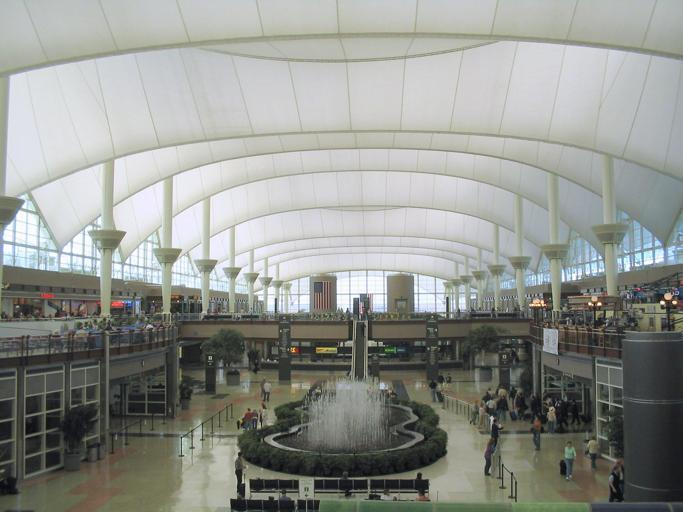

In [17]:
#image = Image.open('/content/ADE20k_toy_dataset/images/training/ADE_train_00000001.jpg')
# on your local machine
root_dir_inf = os.path.join(root_dir,"images/training/ADE_train_00000001.jpg")
image = Image.open(root_dir_inf)
image

In [39]:
# prepare the image for the model
pixel_values = image_processor(image, return_tensors="pt").pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 512, 512])


In [40]:
import torch

# forward pass
with torch.no_grad():
  outputs = model(pixel_values=pixel_values)

In [41]:
# logits are of shape (batch_size, num_labels, height/4, width/4)
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 150, 128, 128])


In [42]:
def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]

In [43]:
predicted_segmentation_map = image_processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()
print(predicted_segmentation_map)

[[0 0 0 ... 5 5 5]
 [0 0 0 ... 5 5 5]
 [0 0 0 ... 5 5 5]
 ...
 [3 3 3 ... 0 0 0]
 [3 3 3 ... 0 0 0]
 [3 3 3 ... 0 0 0]]


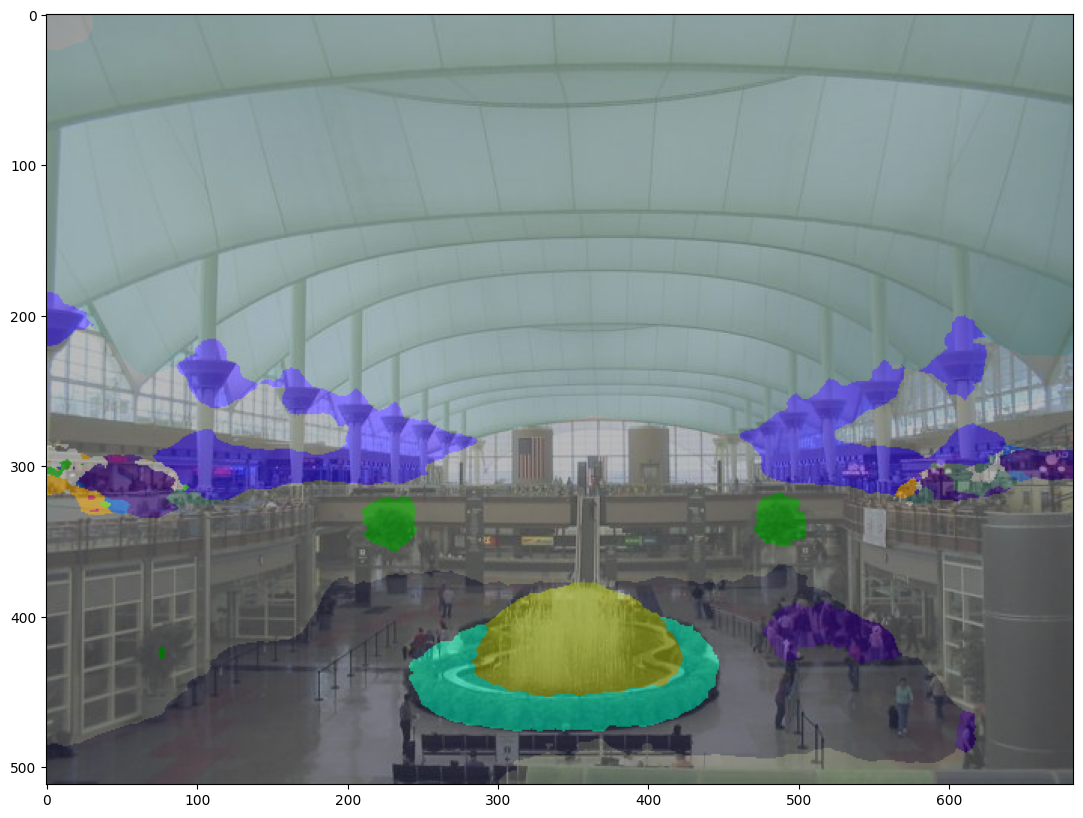

In [44]:
import matplotlib.pyplot as plt
import numpy as np

color_seg = np.zeros((predicted_segmentation_map.shape[0],
                      predicted_segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3

palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[predicted_segmentation_map == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

Compare this to the ground truth segmentation map:

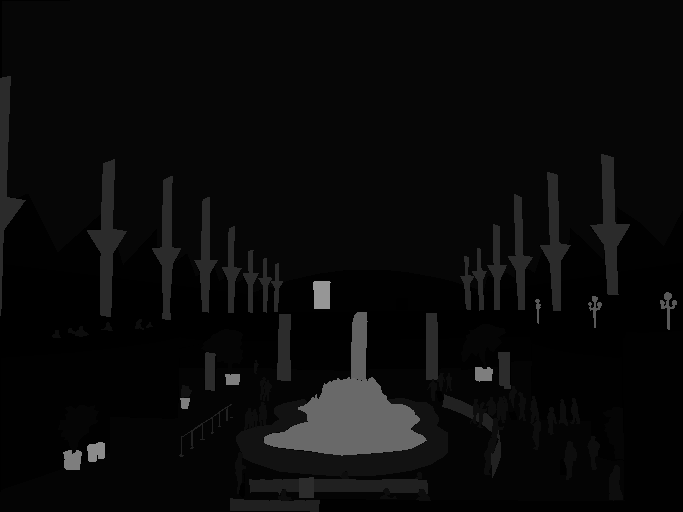

In [18]:
root_dir_mask = os.path.join(root_dir,"annotations/training/ADE_train_00000001.png")
map = Image.open(root_dir_mask)
map

Classes in this image: ['wall', 'floor', 'tree', 'ceiling', 'person', 'plant', 'seat', 'fence', 'column', 'signboard', 'streetlight', 'escalator', 'fountain', 'pot', 'ashcan', 'flag', None]


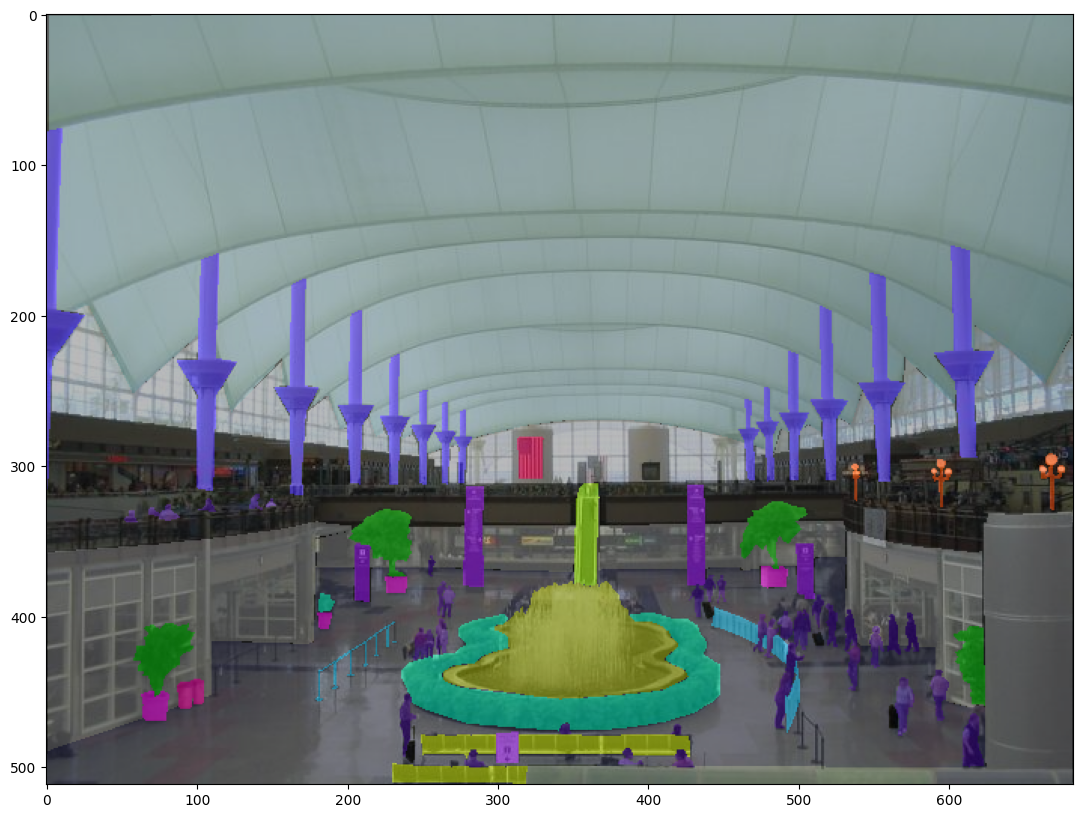

In [47]:
# convert map to NumPy array
map = np.array(map)
map[map == 0] = 255 # background class is replaced by ignore_index
map = map - 1 # other classes are reduced by one
map[map == 254] = 255

classes_map = np.unique(map).tolist()
unique_classes = [model.config.id2label[idx] if idx!=255 else None for idx in classes_map]
print("Classes in this image:", unique_classes)

# create coloured map
color_seg = np.zeros((map.shape[0], map.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[map == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

Let's compute the metrics:

In [48]:
# metric expects a list of numpy arrays for both predictions and references
metrics = metric._compute(
                  predictions=[predicted_segmentation_map],
                  references=[map],
                  num_labels=len(id2label),
                  ignore_index=255,
                  reduce_labels=False, # we've already reduced the labels ourselves
              )

/home/helldiver/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/home/helldiver/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


In [49]:
metrics.keys()

dict_keys(['mean_iou', 'mean_accuracy', 'overall_accuracy', 'per_category_iou', 'per_category_accuracy'])

In [50]:
import pandas as pd

# print overall metrics
for key in list(metrics.keys())[:3]:
  print(key, metrics[key])

# pretty-print per category metrics as Pandas DataFrame
metric_table = dict()
for id, label in id2label.items():
    metric_table[label] = [
                           metrics["per_category_iou"][id],
                           metrics["per_category_accuracy"][id]
    ]

print("---------------------")
print("per-category metrics:")
pd.DataFrame.from_dict(metric_table, orient="index", columns=["IoU", "accuracy"])

mean_iou 0.2566749063424118
mean_accuracy 0.3534676666229917
overall_accuracy 0.8822370737370309
---------------------
per-category metrics:


IoU  accuracy
wall      0.759991  0.955641
building       NaN       NaN
sky            NaN       NaN
floor     0.705457  0.844677
tree      0.340341  0.354001
...            ...       ...
shower         NaN       NaN
radiator       NaN       NaN
glass          NaN       NaN
clock          NaN       NaN
flag      0.000000  0.000000

[150 rows x 2 columns]